In [3]:
import numpy as np
from chmm_actions import CHMM, forwardE, datagen_structured_obs_room
import matplotlib.pyplot as plt
import igraph
from matplotlib import cm, colors
import os, sys, pickle

retrain_models = False

custom_colors = (
    np.array(
        [
            [214, 214, 214],
            [85, 35, 157],
            [253, 252, 144],
            [114, 245, 144],
            [151, 38, 20],
            [239, 142, 192],
            [214, 134, 48],
            [140, 194, 250],
            [72, 160, 162],
        ]
    )
    / 256
)

if not os.path.exists("figures"):
    os.makedirs("figures")

In [4]:
def plot_graph(
    chmm, x, a, output_file, cmap=cm.Spectral, multiple_episodes=False, vertex_size=30
):
    states = chmm.decode(x, a)[1]

    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True)

    g = igraph.Graph.Adjacency((A > 0).tolist())
    node_labels = np.arange(x.max() + 1).repeat(n_clones)[v]
    if multiple_episodes:
        node_labels -= 1
    colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]
    out = igraph.plot(
        g,
        output_file,
        layout=g.layout("kamada_kawai"),
        vertex_color=colors,
        vertex_label=v,
        vertex_size=vertex_size,
        margin=50,
    )

    return out

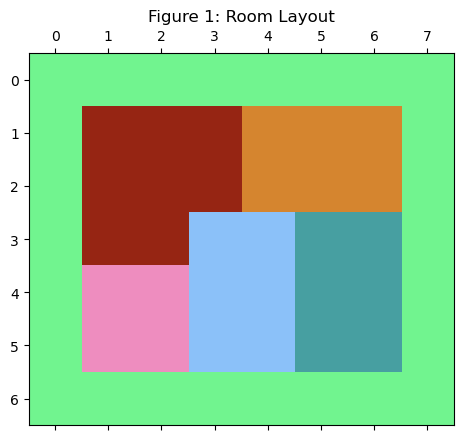

In [5]:
room = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 3, 3, 3, 0],
    [0, 1, 1, 1, 3, 3, 3, 0],
    [0, 1, 1, 4, 4, 5, 5, 0],
    [0, 2, 2, 4, 4, 5, 5, 0],
    [0, 2, 2, 4, 4, 5, 5, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]
])


# Plot the layout of the room
cmap = colors.ListedColormap(custom_colors[-6:])
plt.matshow(room, cmap=cmap)
plt.title('Figure 1: Room Layout')
plt.savefig("figures/rectangular_room_layout.pdf")

In [6]:
# Generate data from the room and train a CSCG. Takes about a minute

n_emissions = room.max() + 1
print('n_emissions', n_emissions)

a, x, rc = datagen_structured_obs_room(room, length=50000)     #Use length=50000 for bigger room
print('a', a)
print('x', x)
print('rc', rc)


n_emissions 6
a [0 2 2 ... 2 1 0]
x [0 0 2 ... 2 2 2]
rc [[6 3]
 [6 2]
 [5 2]
 ...
 [5 1]
 [4 1]
 [4 2]]


In [7]:
n_clones = np.ones(n_emissions, dtype=np.int64) * 70
print('n_clones', n_clones)

name = 'custom_maze-same_boundary'
file = os.path.join("models", f"{name}.pkl")
if os.path.isfile(file) and not retrain_models:
    with open(file, 'rb') as f:
        (chmm, progression) = pickle.load(f)
else:
    chmm = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, seed=42)  # Initialize the model
    progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training   use n_iter=1000 for better training
    with open(file, 'wb') as f: # open a text file
        pickle.dump((chmm, progression), protocol=5, file=f) # Serializes model object



n_clones [70 70 70 70 70 70]


In [8]:
# Consolidate learning. Takes a few seconds
chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

  3%|▎         | 3/100 [00:06<03:36,  2.23s/it, train_bps=0.0174]


[np.float32(0.02422625),
 np.float32(0.017380824),
 np.float32(0.01737989),
 np.float32(0.01737989)]

In [20]:
states = chmm.decode(x, a)[1]
v = np.unique(states)

T = chmm.C[:, v][:, :, v]
A = T.sum(0)
A /= A.sum(1, keepdims=True)

g = igraph.Graph.Adjacency((A > 0).tolist())

[v.index for v in g.vs]
[(e.source, e.target) for e in g.es]


[(0, 0),
 (0, 18),
 (0, 21),
 (0, 31),
 (1, 1),
 (1, 14),
 (1, 23),
 (1, 42),
 (2, 2),
 (2, 5),
 (2, 19),
 (2, 28),
 (3, 3),
 (3, 7),
 (3, 22),
 (3, 46),
 (4, 4),
 (4, 6),
 (4, 11),
 (4, 51),
 (5, 2),
 (5, 5),
 (5, 16),
 (5, 25),
 (6, 4),
 (6, 6),
 (6, 23),
 (6, 49),
 (7, 3),
 (7, 7),
 (7, 13),
 (7, 44),
 (8, 8),
 (8, 10),
 (8, 17),
 (9, 9),
 (9, 12),
 (9, 21),
 (9, 38),
 (10, 8),
 (10, 10),
 (10, 22),
 (10, 33),
 (11, 4),
 (11, 11),
 (11, 20),
 (11, 54),
 (12, 9),
 (12, 12),
 (12, 14),
 (12, 42),
 (13, 7),
 (13, 13),
 (13, 24),
 (13, 53),
 (14, 1),
 (14, 12),
 (14, 14),
 (15, 15),
 (15, 17),
 (15, 19),
 (15, 34),
 (16, 5),
 (16, 16),
 (16, 18),
 (17, 8),
 (17, 15),
 (17, 17),
 (17, 33),
 (18, 0),
 (18, 16),
 (18, 18),
 (18, 25),
 (18, 30),
 (19, 2),
 (19, 15),
 (19, 19),
 (19, 26),
 (20, 11),
 (20, 20),
 (20, 24),
 (21, 0),
 (21, 9),
 (21, 21),
 (21, 41),
 (22, 3),
 (22, 10),
 (22, 22),
 (22, 35),
 (23, 1),
 (23, 6),
 (23, 23),
 (23, 40),
 (24, 13),
 (24, 20),
 (24, 24),
 (24, 54),
 (

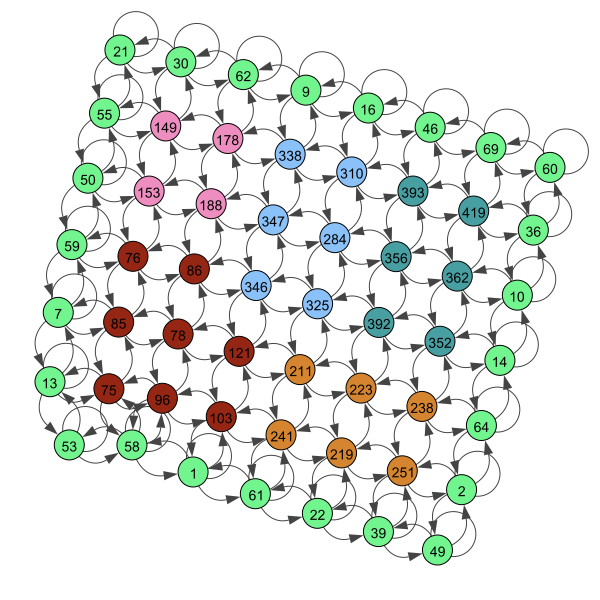

In [10]:
graph = plot_graph(
    chmm, x, a, output_file="figures/custom_maze-same_boundary.pdf", cmap=cmap
)
graph

# Look for the correspondence between the graph and the original layout of the rooom in Figure 1
# Node colors correspond to the observations from the room. Node numbers are the clone/neuron numbers.